In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import RBFInterpolator
from tqdm import tqdm
# from floorplan_utils import *
# from img_utils import *

In [57]:
mpl.rcParams['figure.figsize'] = [15, 15]

# Graph processing

In [58]:
opt_df = pd.read_pickle('./opt_df.pic')

In [59]:
opt_df

wf   gnss_lat  \
step_id                                                                 
1        {'207394925875571': -47, '207394925875570': -4...        NaN   
2                                                     None  55.942823   
3                                                     None        NaN   
4                                                     None        NaN   
5                                                     None        NaN   
...                                                    ...        ...   
106334   {'207394925917588': -83, '207394925917587': -8...        NaN   
106335                                                None        NaN   
106336                                                None        NaN   
106337                                                None        NaN   
106338   {'207394925917588': -85, '207394925917587': -8...        NaN   

         gnss_lon         z     z_raw  is_baro           t          x  \
step_id                                                                 
1             NaN -0.003880  0.000000     True   5455892.0  19.429567   
2        -3.18914 -0.003880  0.000000     True   5455992.0  19.415120   
3             NaN -0.003880  0.000000     True   5456252.0  19.310557   
4             NaN -0.003880  0.000000     True   5456482.0  19.195583   
5             NaN -0.003880  0.000000     True   5456692.0  19.073481   
...           ...       ...       ...      ...         ...        ...   
106334        NaN -0.011057  0.522397     True  11123112.0  16.343454   
106335        NaN -0.011057  0.547007     True  11123832.0  16.132462   
106336        NaN -0.011057  0.553463     True  11124532.0  15.920868   
106337        NaN -0.011057  0.553463     True  11125152.0  15.706710   
106338        NaN -0.011057  0.553463     True  11126092.0  15.362724   

                 y  pdr_vel  ...  traj_id  gnss_easting  gnss_northing  theta  \
step_id                      ...                                                
1        25.583819  0.69723  ...        0           NaN            NaN      0   
2        25.540276  0.74234  ...        0     -8.031963       7.682255      0   
3        25.395203  0.84942  ...        0           NaN            NaN      0   
4        25.262586  0.93122  ...        0           NaN            NaN      0   
5        25.141082  0.99524  ...        0           NaN            NaN      0   
...            ...      ...  ...      ...           ...            ...    ...   
106334   -5.394785  0.27198  ...      193           NaN            NaN      0   
106335   -5.426694  0.27993  ...      193           NaN            NaN      0   
106336   -5.465603  0.30507  ...      193           NaN            NaN      0   
106337   -5.494010  0.33709  ...      193           NaN            NaN      0   
106338   -5.545816  0.34296  ...      193           NaN            NaN      0   

        is_elevation floor_id elevation_height   max_dist        lat       lon  
step_id                                                                         
1              False      0.0              0.0  42.583348  55.942983 -3.188700  
2              False      0.0              0.0  42.583348  55.942983 -3.188700  
3              False      0.0              0.0  42.583348  55.942982 -3.188702  
4              False      0.0              0.0  42.583348  55.942980 -3.188704  
5              False      0.0              0.0  42.583348  55.942979 -3.188706  
...              ...      ...              ...        ...        ...       ...  
106334         False      0.0              0.0  10.426916  55.942705 -3.188749  
106335         False      0.0              0.0  10.426916  55.942705 -3.188753  
106336         False      0.0              0.0  10.426916  55.942704 -3.188756  
106337         False      0.0              0.0  10.426916  55.942704 -3.188760  
106338         False      0.0              0.0  10.426916  55.942704 -3.188765  

[101250 rows x 28 columns]

In [60]:
opt_df['x'].min()

-14.336349469974367

In [61]:
opt_df['x'].max()

23.047132921048554

In [62]:
opt_df['y'].min()

-32.87111300736769

In [63]:
opt_df['y'].max()

29.7023697005688

In [64]:
opt_df['floor_id'].min()

0.0

In [65]:
floor = 0.0
x_min = -35
x_max = 35
y_min = -35
y_max = 30
resolution = 0.1 # meters per pixel
# traj_pix = opt_df.copy()
traj_pix = pd.DataFrame()
traj_pix['x_img'] = ((opt_df[opt_df['floor_id']==floor]['x'] - x_min) // resolution).astype(int)
traj_pix['y_img'] = ((y_max - opt_df[opt_df['floor_id']==floor]['y']) // resolution).astype(int)
traj_pix = traj_pix.drop_duplicates(ignore_index=True)

100%|██████████| 49448/49448 [00:02<00:00, 16575.52it/s]


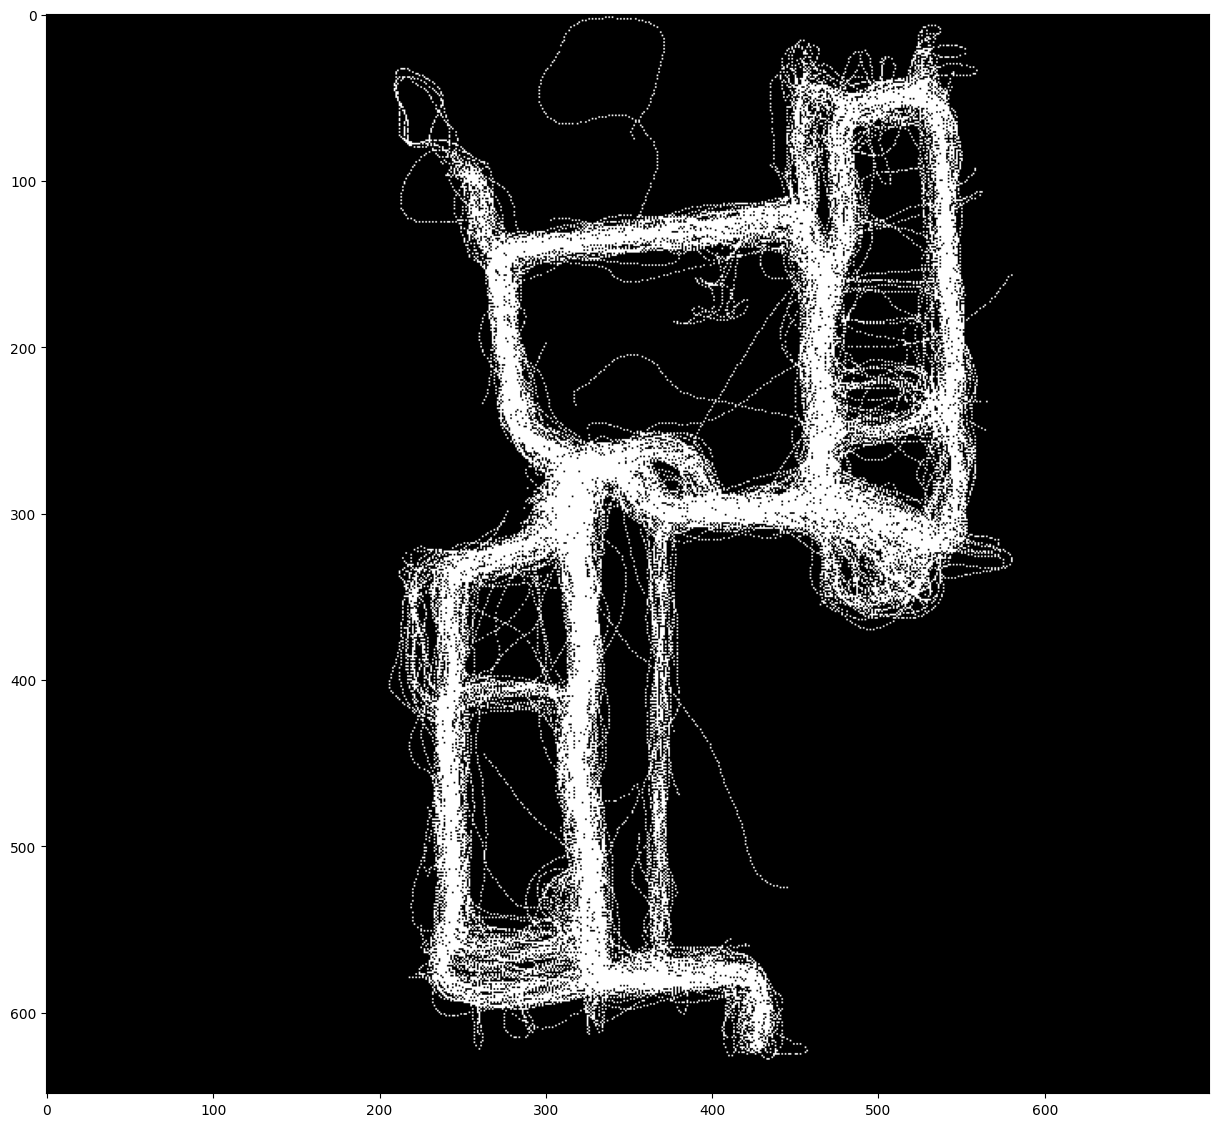

In [66]:
img_size_x = int((x_max - x_min) // resolution)
img_size_y = int((y_max - y_min) // resolution)
traj_img = np.zeros([img_size_y, img_size_x]).astype('uint8')
for i in tqdm(range(len(traj_pix))):
    traj_img[traj_pix.iloc[i,1], traj_pix.iloc[i,0]] = 255
plt.imshow(traj_img, cmap='gray')

In [67]:
traj_img.shape

(649, 699)

In [68]:
np.save('ml_traj.npy', traj_img)

# Map processing

In [69]:
img_file = './2.png'
# pgw_file = r'C:\Users\p50023028\Documents\data\beijing_shoudu_t2\output\beijing_shoudu_t2_20220609_0302_0430\maps\2\2.pgw'

In [70]:
# pgw = load_floorplan_pgw(pgw_file)

In [71]:
img = cv.imread(img_file)

In [72]:
# image_data = image_enu_data(img, pgw)

In [73]:
# image_data

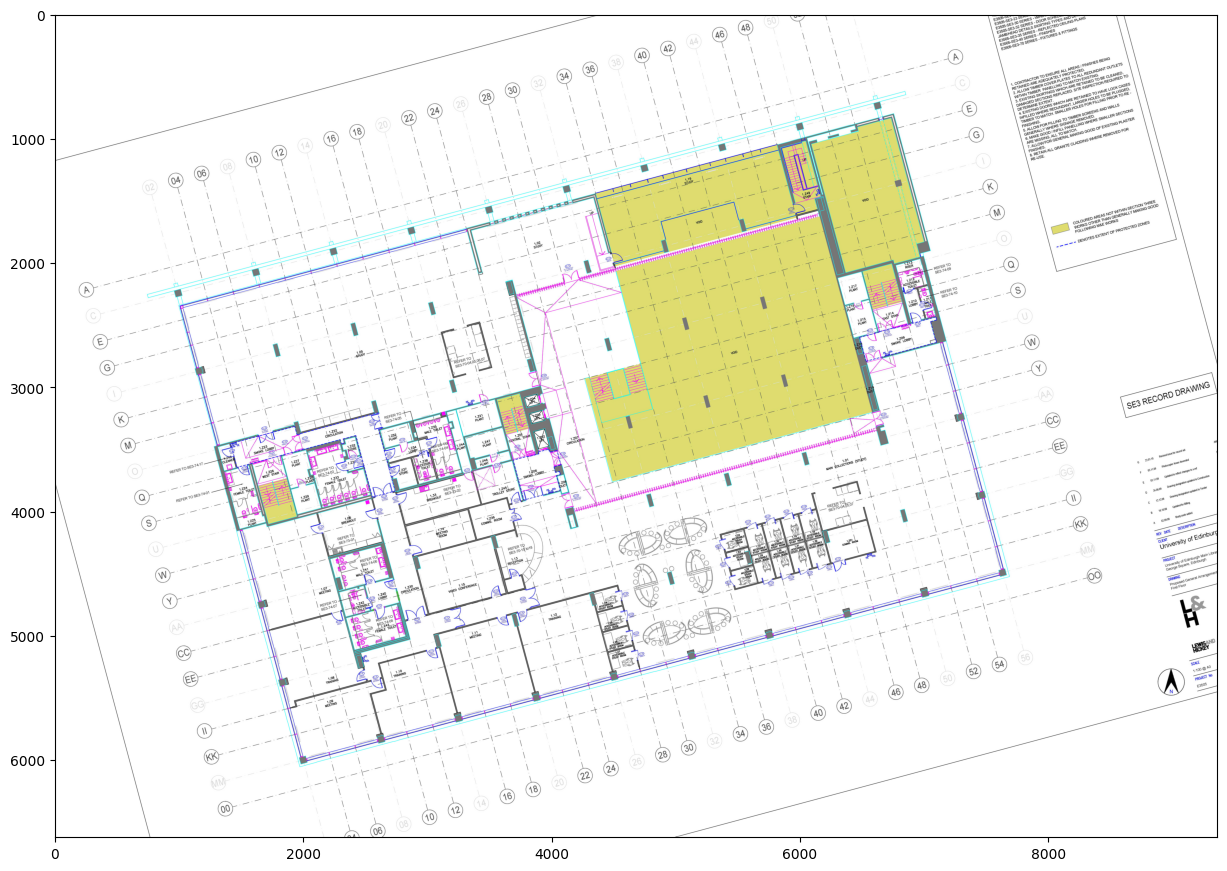

In [74]:
plt.imshow(img, cmap='gray')

In [75]:
img.shape

(6623, 9362, 3)

In [76]:
img_grey = img[:,:,0]
# img_grey = img
img_grey.shape

(6623, 9362)

In [84]:
WIDTH = 9362
HEIGHT = 6623
dim = (WIDTH, HEIGHT)

In [85]:
resized = cv.resize(img, dim, interpolation = cv.INTER_CUBIC)
resized.shape

(6623, 9362, 3)

In [83]:
img_background = resized[:,:,0]

IndexError: index 3 is out of bounds for axis 2 with size 3

In [26]:
img_foreground = resized[:,:,:3]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [27]:
img_grey = img_foreground.max(axis=2)

NameError: name 'img_foreground' is not defined

In [28]:
img_background_inverse = 255 - resized[:,:,3]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [29]:
img_background_inverse = erosion(img_background_inverse, 5)

NameError: name 'erosion' is not defined

In [30]:
img_grey+=img_background_inverse

NameError: name 'img_grey' is not defined

In [31]:
np.save('forum_radiomap/forum_f0_map.npy', img)

# Load manually selected feature points

Read points and flip from (x, y) to (y, x)

In [32]:
traj_gt = np.load('forum_f0_traj_gt_pix.npy')
map_gt = np.load('forum_f0_map_gt_pix.npy')
traj_gt = np.flip(traj_gt, axis=1)
map_gt = np.flip(map_gt, axis=1)

In [33]:
print(map_gt.shape)
print(traj_gt.shape)

(11, 2)
(11, 2)


In [34]:
map_gt

array([[ 560,  178],
       [ 518,  334],
       [ 712,  384],
       [ 658,  586],
       [ 944, 1138],
       [1198, 1210],
       [1134, 1478],
       [ 928, 1418],
       [ 756,  778],
       [ 564, 1420],
       [1038,  694]])

In [35]:
traj_gt

array([[369, 108],
       [347, 136],
       [379, 167],
       [342, 227],
       [357, 394],
       [430, 437],
       [375, 500],
       [334, 470],
       [352, 280],
       [255, 419],
       [423, 282]])

# Load images

```map_img``` and ```traj_img``` contains matching points (x, y) in IMAGE COORDINATES.

In [36]:
map_img = np.load('forum_f0_map.npy')
traj_img = np.load('forum_f0_traj.npy')

In [37]:
print(map_img.shape)
print(traj_img.shape)

(1684, 2384)
(699, 699)


# Interpolate

The ```grid``` is in (y, x) sequence, as in usual numpy definition.

In [38]:
grid = np.mgrid[0:HEIGHT, 0:WIDTH]
grid_flat = grid.reshape(2, -1).T

Data point coordinates: ```map_gt```

Interpolation target values: ```traj_gt```

Data grid of map coordinates: ```grid_flat```

Resulting grid of interpolated trajectory coordinates: ```grid_z_rbf```

In [39]:
grid_z_rbf = RBFInterpolator(map_gt, traj_gt)(grid_flat)
grid_z_rbf_reshape = grid_z_rbf.reshape(HEIGHT, WIDTH, 2)

The resulting interpolation is in (y, x) sequence.

# Warp image

In [40]:
map_x = np.append([], [ar[:,1] for ar in grid_z_rbf_reshape]).reshape(HEIGHT, WIDTH)
map_y = np.append([], [ar[:,0] for ar in grid_z_rbf_reshape]).reshape(HEIGHT, WIDTH)
map_x_32 = map_x.astype('float32')
map_y_32 = map_y.astype('float32')

```remap()``` takes a vector field where each vector points to the pixel of the source image.

```map_x_32``` and ```map_y_32``` describes the vector field. They are in the same shape of the image, aka, HxW.

Or else, the vector field can also be described by a 3D HxWx2 shape array. 

The pixel values are stored in ```traj_img```. ```map_x_32``` and ```map_y_32``` tells the algorithm where to fetch the pixel value in ```traj_img``` in order to fill the warped image.

In [41]:
warped_image = cv.remap(traj_img, map_x_32, map_y_32, cv.INTER_CUBIC)

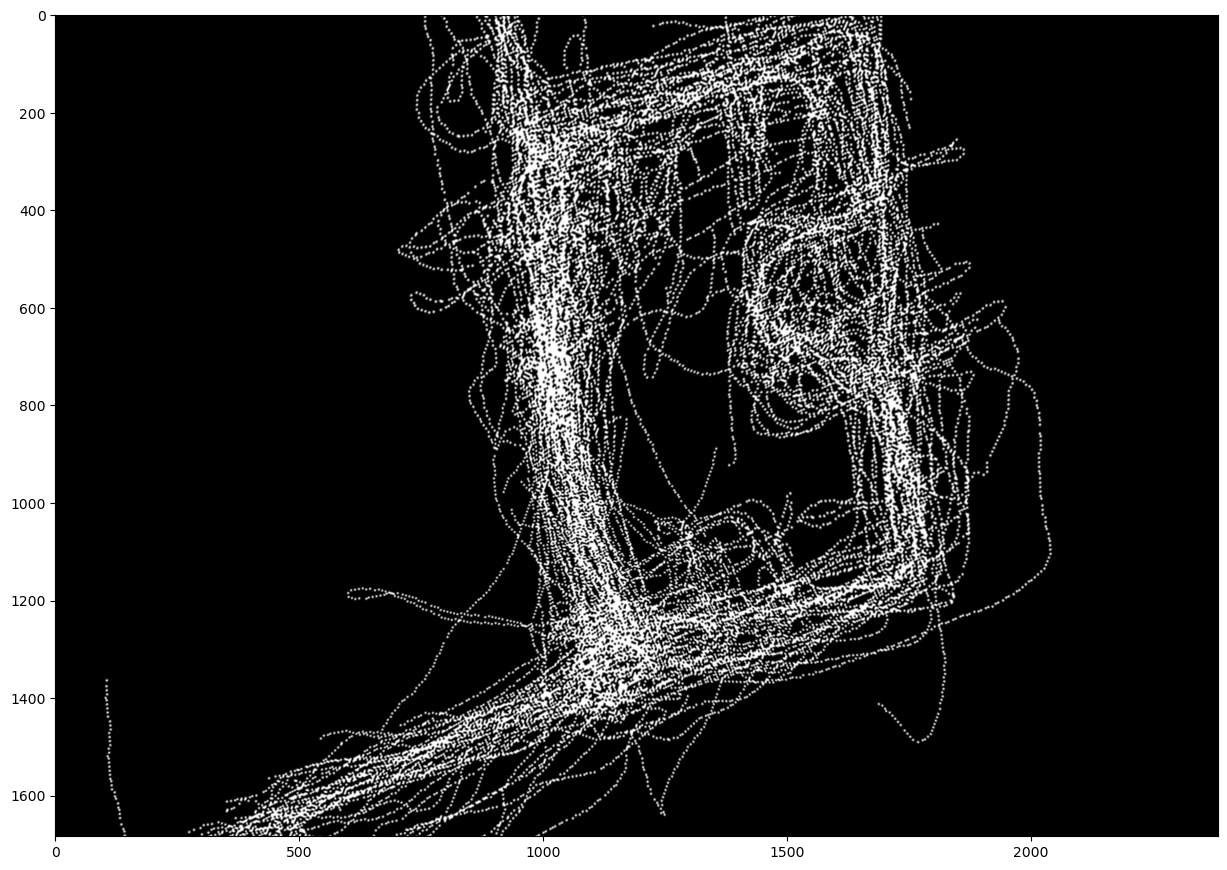

In [42]:
plt.imshow(warped_image, cmap='gray')

# Overlay images

In [33]:
warped_flip = (map_img - warped_image).astype('int')

In [34]:
viz = np.stack((map_img, warped_flip, warped_flip), axis=2)

In [35]:
map_img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

Text(0, 0.5, 'Y (North)')

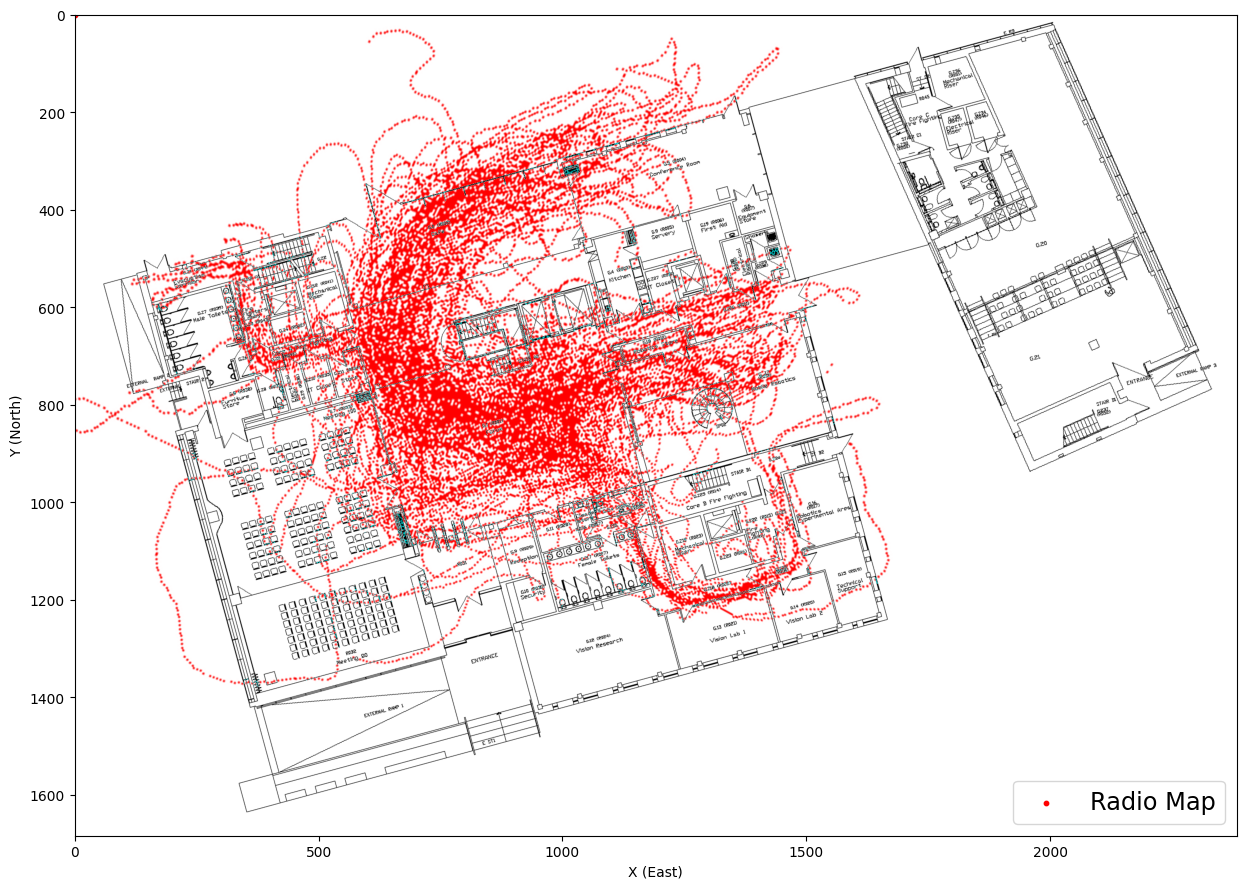

In [36]:
plt.imshow(viz)
plt.scatter(0, 0, label='Radio Map', c='r', s=10)
plt.legend(loc=4, fontsize='xx-large')
plt.xlabel('X (East)')
plt.ylabel('Y (North)')

# Apply to whole graph

In order to get the Lat Long value of the whole graph, the reverse of the above interpolation needs to be used:

Rather than mapping the graph to the floor plan, we need to map the floor plan to the graph.

In [43]:
floor = 0.0
x_min = -35
x_max = 35
y_min = -35
y_max = 30
resolution = 1.0 # meters per pixel
# traj_pix = opt_df.copy()
traj_pix = pd.DataFrame()
traj_pix['x_img'] = ((opt_df[opt_df['floor_id']==floor]['x'] - x_min) / resolution)
traj_pix['y_img'] = ((y_max - opt_df[opt_df['floor_id']==floor]['y']) / resolution)
traj_pix['wf'] = opt_df[opt_df['floor_id']==floor]['wf']
traj_pix['t'] = opt_df[opt_df['floor_id']==floor]['t']
traj_pix['orig_step_id'] = opt_df[opt_df['floor_id']==floor]['orig_step_id']
traj_pix['step_id'] = opt_df[opt_df['floor_id']==floor]['step_id']
traj_pix['traj_id'] = opt_df[opt_df['floor_id']==floor]['traj_id']
traj_pix['pdr_vel'] = opt_df[opt_df['floor_id']==floor]['pdr_vel']
traj_pix['pdr_head'] = opt_df[opt_df['floor_id']==floor]['pdr_head']
traj_pix['pdr_dist'] = opt_df[opt_df['floor_id']==floor]['pdr_dist']
traj_pix['pdr_still'] = opt_df[opt_df['floor_id']==floor]['pdr_still']
traj_pix['theta'] = opt_df[opt_df['floor_id']==floor]['theta']

In [44]:
# traj_pix = traj_pix.dropna()

In [45]:
traj_pix

x_img      y_img   
step_id                         
532      35.431801  35.767934  \
533      35.306563  35.929459   
534      35.185307  36.086154   
535      35.060833  36.243238   
536      34.931895  36.397509   
...            ...        ...   
97847    41.656851  40.562643   
97848    41.505445  40.420346   
97849    41.351160  40.285054   
97850    41.070837  40.049556   
97851    41.077205  39.863069   

                                                        wf            t   
step_id                                                                   
532      {'202560769871667': -78, '202560769871666': -7...   25057323.0  \
533                                                   None   25057533.0   
534                                                   None   25057743.0   
535                                                   None   25057963.0   
536                                                   None   25058193.0   
...                                                    ...          ...   
97847                                                 None  629908836.0   
97848                                                 None  629909076.0   
97849                                                 None  629909356.0   
97850    {'202560769888307': -77, '202560769888306': -7...  629910226.0   
97851                                                 None  629911826.0   

         orig_step_id  step_id  traj_id  pdr_vel   pdr_head   pdr_dist   
step_id                                                                  
532                 1      532        1  1.00923    0.05893    0.01009  \
533                22      533        1  0.98085    0.39575    0.21896   
534                43      534        1  0.94974    0.12974    0.42156   
535                65      535        1  0.91440   -0.86524    0.62649   
536                88      536        1  0.87512   -2.79763    0.83212   
...               ...      ...      ...      ...        ...        ...   
97847           11998    97847      191  0.92004  105.38444  110.82771   
97848           12022    97848      191  0.80399 -148.60511  111.03424   
97849           12050    97849      191  0.65476  -13.98875  111.23834   
97850           12137    97850      191  0.23851   -5.44625  111.60382   
97851           12297    97851      191  0.18349  -67.15992  111.85313   

         pdr_still  theta  
step_id                    
532          False      0  
533          False      0  
534          False      0  
535          False      0  
536          False      0  
...            ...    ...  
97847        False      0  
97848        False      0  
97849        False      0  
97850        False      0  
97851        False      0  

[28339 rows x 12 columns]

In [46]:
traj_gt = np.load('forum_f0_traj_gt_meter.npy')
map_gt = np.load('forum_f0_map_gt_meter.npy')
traj_gt = np.flip(traj_gt, axis=1)
map_gt = np.flip(map_gt, axis=1)

```map_gt``` stores (y, x) in image coordinates, in meters.

```y``` needs to be the opposite for ENU coordinates.

In [47]:
map_gt_enu = map_gt.copy()
map_gt_enu[:, 0] = -map_gt_enu[:, 0] 

Translate to wgs

In [48]:
# map_gt_wgs = []
# for y, x in map_gt_enu:
#     wgs = enu_to_wgs(x, y, pgw)
#     map_gt_wgs.append(wgs)
# map_gt_wgs = np.array(map_gt_wgs)

Method 1: Interpolate map points based on graph grid.

In [49]:
# grid = np.mgrid[0:1000, 0:500]
# grid_flat = grid.reshape(2, -1).T
# grid_z = RBFInterpolator(traj_gt, map_gt_wgs)(grid_flat)

In [50]:
np.mgrid[0:65:0.1, 0:70]

array([[[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0.1,  0.1,  0.1, ...,  0.1,  0.1,  0.1],
        [ 0.2,  0.2,  0.2, ...,  0.2,  0.2,  0.2],
        ...,
        [64.7, 64.7, 64.7, ..., 64.7, 64.7, 64.7],
        [64.8, 64.8, 64.8, ..., 64.8, 64.8, 64.8],
        [64.9, 64.9, 64.9, ..., 64.9, 64.9, 64.9]],

       [[ 0. ,  1. ,  2. , ..., 67. , 68. , 69. ],
        [ 0. ,  1. ,  2. , ..., 67. , 68. , 69. ],
        [ 0. ,  1. ,  2. , ..., 67. , 68. , 69. ],
        ...,
        [ 0. ,  1. ,  2. , ..., 67. , 68. , 69. ],
        [ 0. ,  1. ,  2. , ..., 67. , 68. , 69. ],
        [ 0. ,  1. ,  2. , ..., 67. , 68. , 69. ]]])

In [51]:
grid = np.mgrid[0:70:0.1, 0:65:0.1]
grid_flat = grid.reshape(2, -1).T
grid_z = RBFInterpolator(traj_gt, map_gt_enu)(grid_flat)

In [52]:
def find_nearest(array, value):
    idx = (np.linalg.norm(array - value, axis=1)).argmin()
    return idx

In [53]:
graph_wgs = []
for i in tqdm(range(traj_pix.shape[0])):
    value = np.array([traj_pix['y_img'].iloc[i], traj_pix['x_img'].iloc[i]])
    idx = find_nearest(grid_flat, value)
    graph_wgs.append(grid_z[idx])
graph_wgs = np.array(graph_wgs)

100%|█████████████████████████████████████████████████████████████| 28339/28339 [01:19<00:00, 355.45it/s]


In [194]:
traj_pix['lat'] = graph_wgs[:, 0].copy()
traj_pix['lon'] = graph_wgs[:, 1].copy()

In [54]:
traj_pix['x_meter'] = graph_wgs[:, 1].copy()
traj_pix['y_meter'] = graph_wgs[:, 0].copy()

In [55]:
traj_pix.to_pickle('forum_radiomap/forum_f0_matched_radiomap_all.pic')

Method 2: Interpolate map points based on graph grid.

In [199]:
grid = np.mgrid[0:861, 0:607]
grid_flat = grid.reshape(2, -1).T
grid_z = RBFInterpolator(map_gt, traj_gt)(grid_flat)

In [203]:
graph_pix = []
traj_yx = traj_pix[['y_img', 'x_img']].to_numpy()
for i in tqdm(traj_yx):
    idx = find_nearest(grid_z, i)
    graph_pix.append(grid_flat[idx])
graph_pix = np.array(graph_pix)

100%|████████████████████████████████████████████████████████████████████████████| 78801/78801 [19:06<00:00, 68.71it/s]


In [98]:
traj_pix

x_img       y_img  \
step_id                           
532      354.318009  357.679345   
541      340.828739  369.703629   
555      314.472763  360.620842   
584      252.628455  335.163424   
595      233.482227  342.177927   
...             ...         ...   
97799    487.526631  396.521737   
97808    475.481266  406.351674   
97825    450.686915  425.583516   
97846    418.009206  407.070908   
97850    410.708371  400.495561   

                                                        wf     x_meter  \
step_id                                                                  
532      {'202560769871667': -78, '202560769871666': -7...  105.917878   
541      {'202560769871667': -78, '202560769871666': -7...  105.917878   
555      {'202560769871667': -81, '202560769871666': -8...  105.917878   
584      {'202560769871667': -91, '202560769871666': -9...  105.917878   
595      {'202560769871666': -93, '202560769895697': -9...  105.917878   
...                                                    ...         ...   
97799    {'256040842038041': -73, '202560769849395': -7...  105.917878   
97808    {'256040842038041': -85, '202560769849395': -6...  105.917878   
97825    {'256040842038041': -82, '202560769849395': -6...  105.917878   
97846    {'202560769895698': -92, '202560769895697': -9...  105.917878   
97850    {'202560769888307': -77, '202560769888306': -7...  105.917878   

           y_meter  
step_id             
532      23.045111  
541      23.045111  
555      23.045111  
584      23.045111  
595      23.045111  
...            ...  
97799    23.045111  
97808    23.045111  
97825    23.045111  
97846    23.045111  
97850    23.045111  

[794 rows x 5 columns]

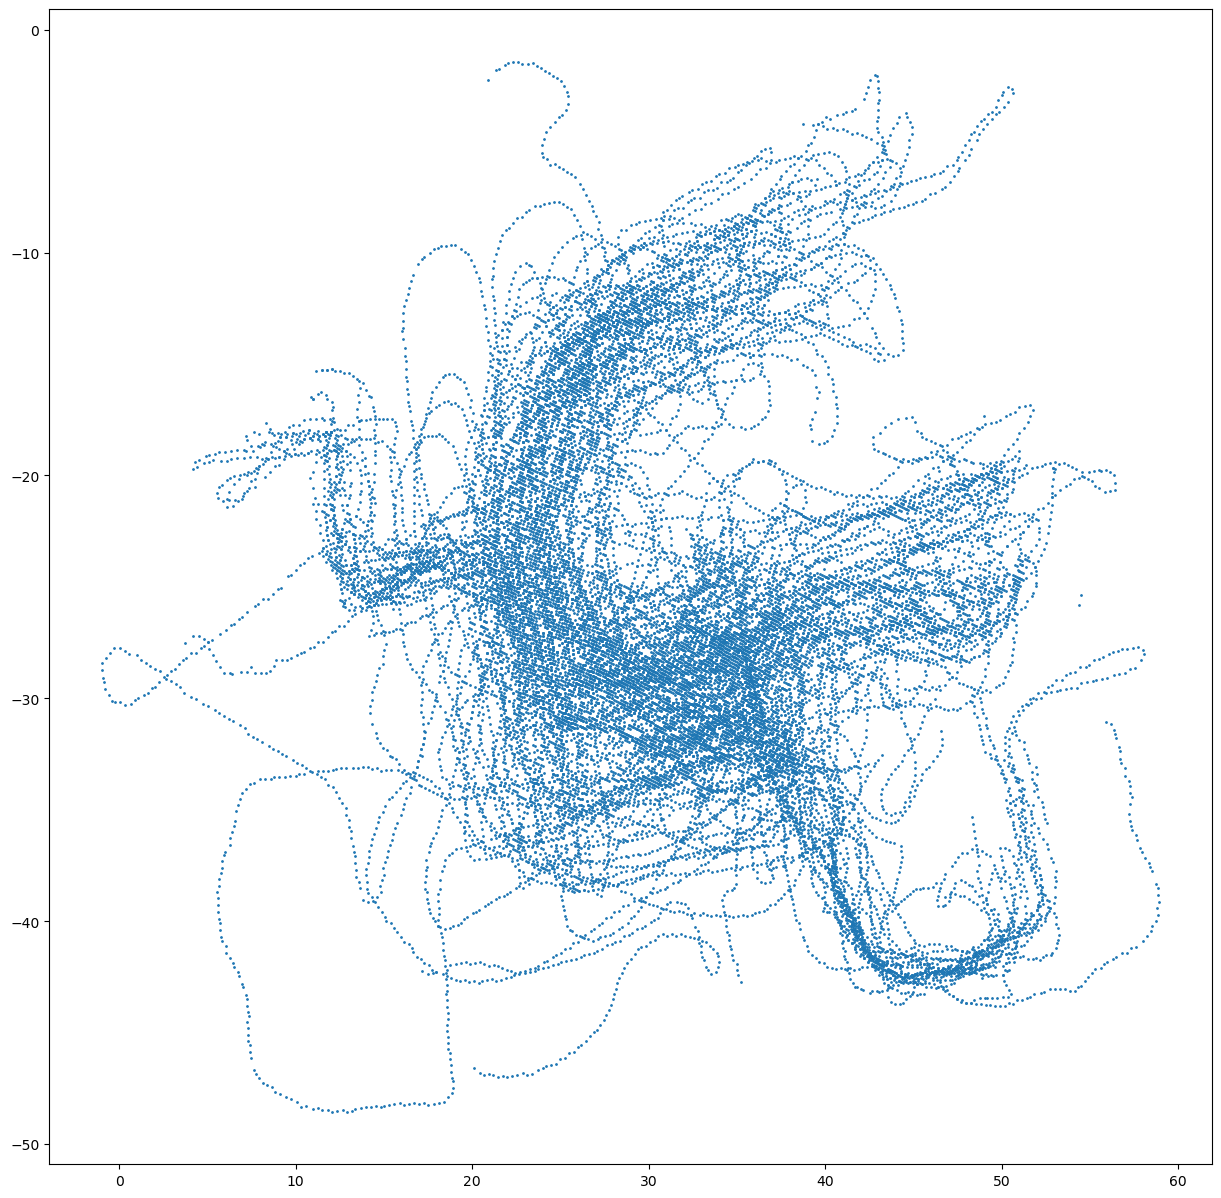

In [56]:
plt.scatter(traj_pix['x_meter'], traj_pix['y_meter'], s=1)

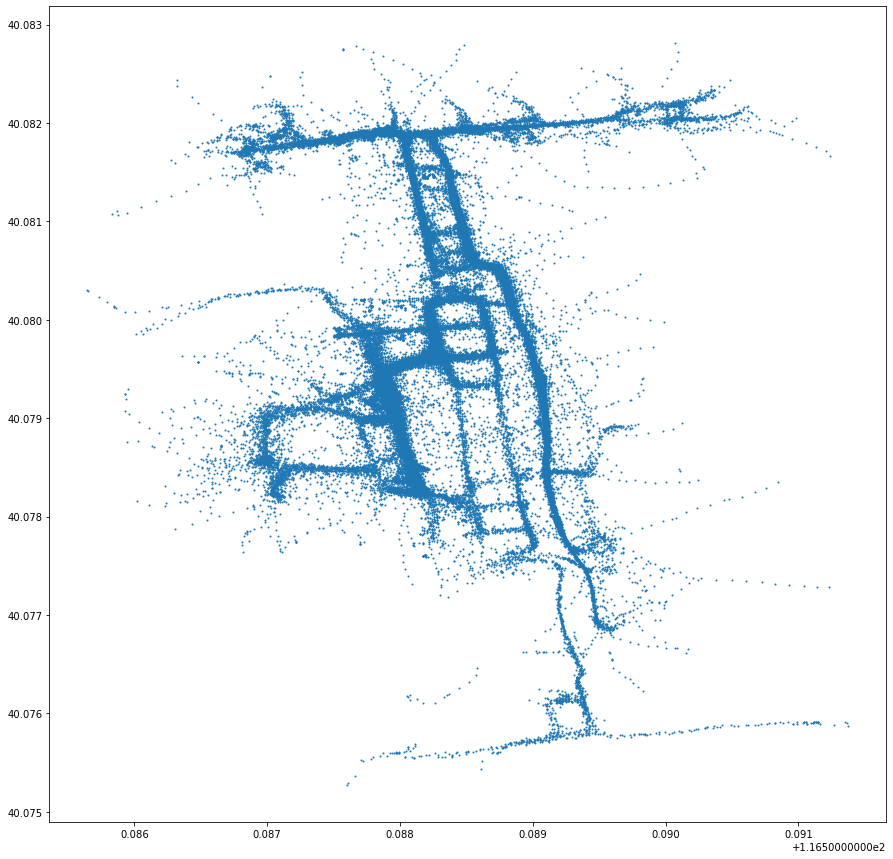

In [198]:
plt.scatter(traj_pix['lon'], traj_pix['lat'], s=1)